In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import tensorflow as tf
from collections import Counter
from wordcloud import WordCloud, STOPWORDS
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.text import Tokenizer
import pickle
from tensorflow.keras.layers import (
    Embedding, LSTM, Dense, Dropout, GlobalMaxPooling1D,
    Bidirectional, Flatten, GRU, Conv1D, MaxPooling1D
)
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import gensim
from gensim.models import Word2Vec
from keras.utils import pad_sequences
from keras.layers import Input, Activation, GlobalMaxPool1D
from keras.models import Sequential
from keras.optimizers import SGD
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers

In [ ]:
# Detect hardware
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver() # TPU detection
except ValueError: # If TPU not found
  tpu = None

In [ ]:
if tpu:
  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)
  strategy = tf.distribute.experimental.TPUStrategy(tpu)
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
else:
  strategy = tf.distribute.get_strategy() # Default strategy that works on CPU and single GPU
  print('Running on CPU instead')
print("Number of accelerators: ", strategy.num_replicas_in_sync)

Running on TPU  ['10.8.34.178:8470']
Number of accelerators:  8


In [ ]:
reddit_full = "/content/drive/MyDrive/UMD-2023-Fall/MSML-651/Final Project/Dataset/databricks data/reddit_token_filtered.csv"
twitter_full = "/content/drive/MyDrive/UMD-2023-Fall/MSML-651/Final Project/Dataset/databricks data/twitter_token_filtered.csv"

In [ ]:
reddit_full = pd.read_csv(reddit_full)
twitter_full = pd.read_csv(twitter_full)

In [ ]:
reddit_full

clean_text  category
0      family mormon never tried explain still stare ...         1
1      buddhism much lot compatible christianity espe...         1
2      seriously say thing first won get complex expl...        -1
3      learned want teach different focus goal wrappi...         0
4      benefit may want read living buddha living chr...         1
...                                                  ...       ...
37019                                       jesus dollar         0
37020  kya bhai pure saal chutiya banaya modi aur jab...         1
37021               downvote karna tha par upvote hogaya         0
37022                                          haha nice         1
37023                          facebook working bjp cell         0

[37024 rows x 2 columns]

<font size = 15, color = yellow> Data Visualization

In [ ]:
# Renaming the category for meaningful insights
mapping = {0: 'Neutral', 1: 'Positive', -1: 'Negative'}

In [ ]:
reddit_full['category'] = reddit_full['category'].map(mapping)
twitter_full['category'] = twitter_full['category'].map(mapping)
reddit_full.head()

clean_text  category
0  family mormon never tried explain still stare ...  Positive
1  buddhism much lot compatible christianity espe...  Positive
2  seriously say thing first won get complex expl...  Negative
3  learned want teach different focus goal wrappi...   Neutral
4  benefit may want read living buddha living chr...  Positive

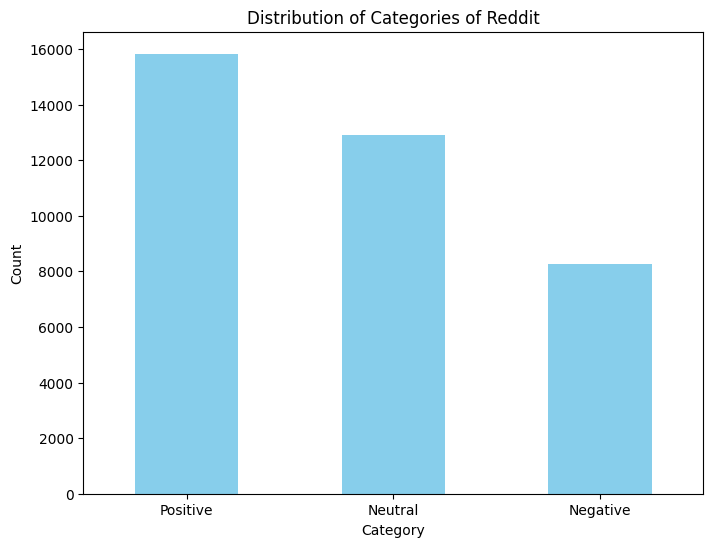

In [ ]:
# Checking the distribution of categories
category_counts = reddit_full['category'].value_counts()
plt.figure(figsize=(8, 6))
category_counts.plot(kind='bar', color='skyblue')
plt.title('Distribution of Categories of Reddit')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

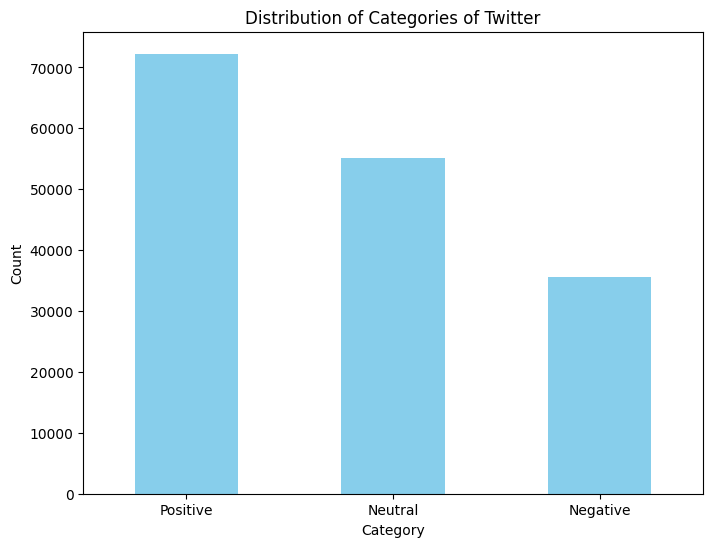

In [ ]:
# Checking the distribution of categories
category_counts = twitter_full['category'].value_counts()
plt.figure(figsize=(8, 6))
category_counts.plot(kind='bar', color='skyblue')
plt.title('Distribution of Categories of Twitter')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

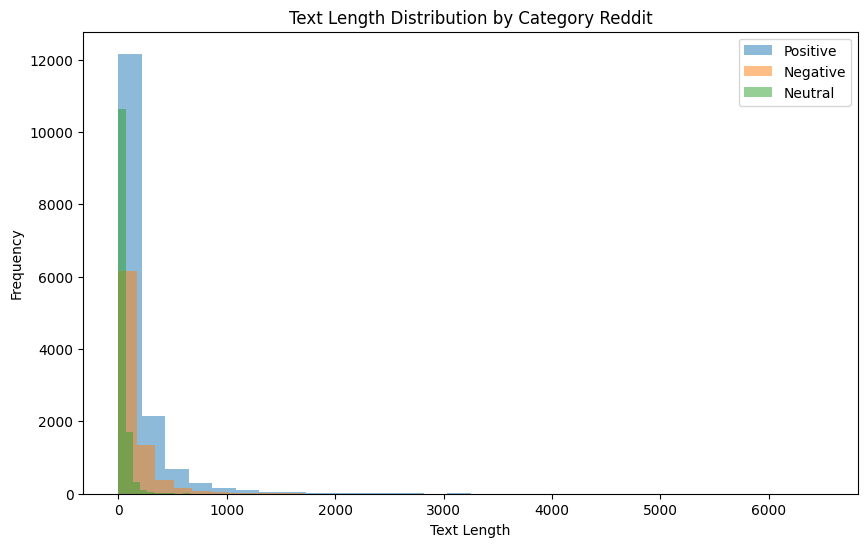

In [ ]:
# Performing Text Length Analysis
reddit_full['text_length'] = reddit_full['clean_text'].apply(len)
plt.figure(figsize=(10, 6))
for category in reddit_full['category'].unique():
    subset = reddit_full[reddit_full['category'] == category]
    plt.hist(subset['text_length'], bins=30, alpha=0.5, label=category)
plt.title('Text Length Distribution by Category Reddit')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.legend()
plt.show()

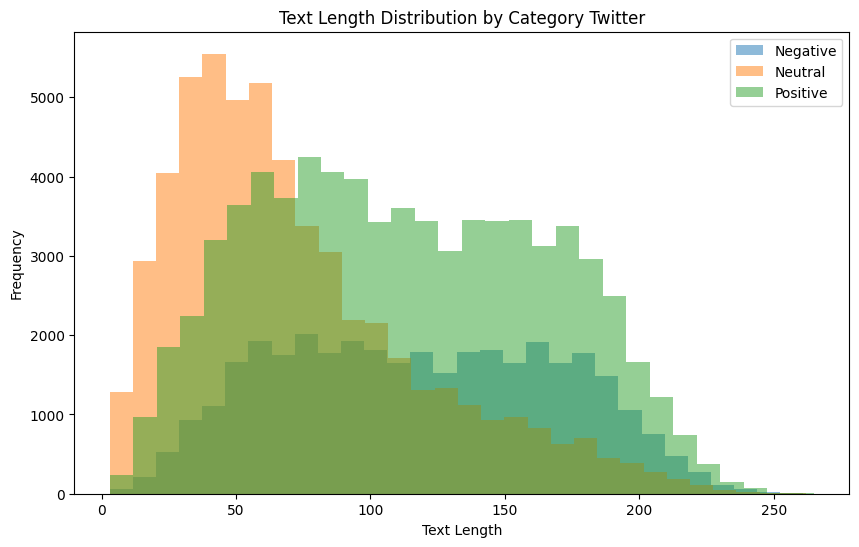

In [ ]:
# Performing Text Length Analysis
twitter_full['text_length'] = twitter_full['clean_text'].apply(len)
plt.figure(figsize=(10, 6))
for category in twitter_full['category'].unique():
    subset = twitter_full[twitter_full['category'] == category]
    plt.hist(subset['text_length'], bins=30, alpha=0.5, label=category)
plt.title('Text Length Distribution by Category Twitter')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [ ]:
reddit_full

clean_text  category  \
0      family mormon never tried explain still stare ...  Positive   
1      buddhism much lot compatible christianity espe...  Positive   
2      seriously say thing first won get complex expl...  Negative   
3      learned want teach different focus goal wrappi...   Neutral   
4      benefit may want read living buddha living chr...  Positive   
...                                                  ...       ...   
37019                                       jesus dollar   Neutral   
37020  kya bhai pure saal chutiya banaya modi aur jab...  Positive   
37021               downvote karna tha par upvote hogaya   Neutral   
37022                                          haha nice  Positive   
37023                          facebook working bjp cell   Neutral   

       text_length  
0              199  
1              968  
2              291  
3               97  
4              474  
...            ...  
37019           12  
37020          106  
37021           36  
37022            9  
37023           25  

[37024 rows x 3 columns]

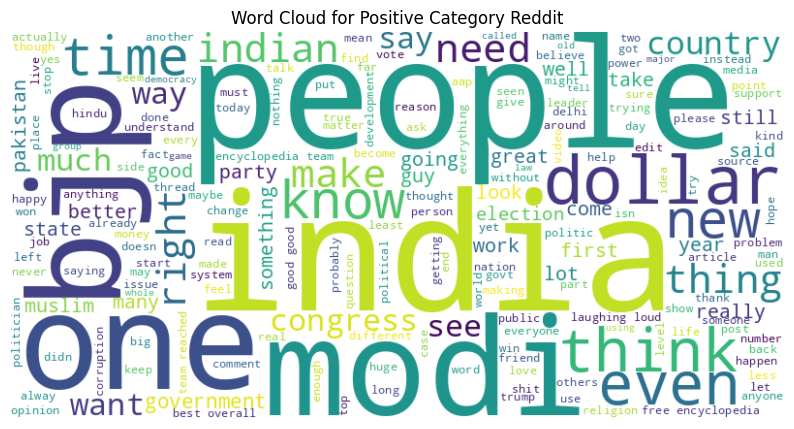

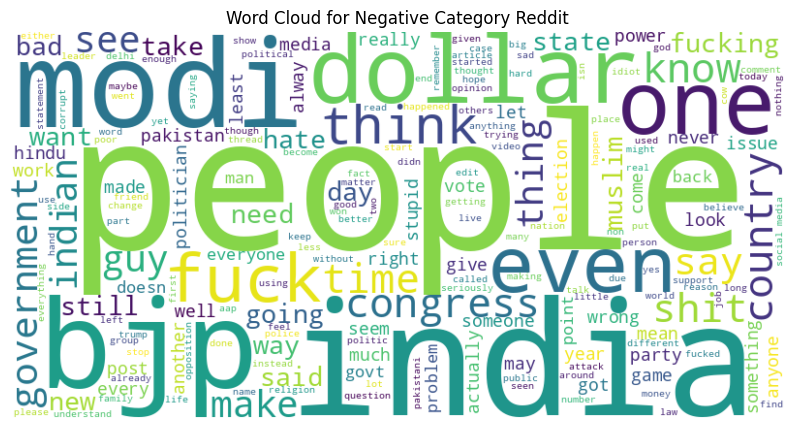

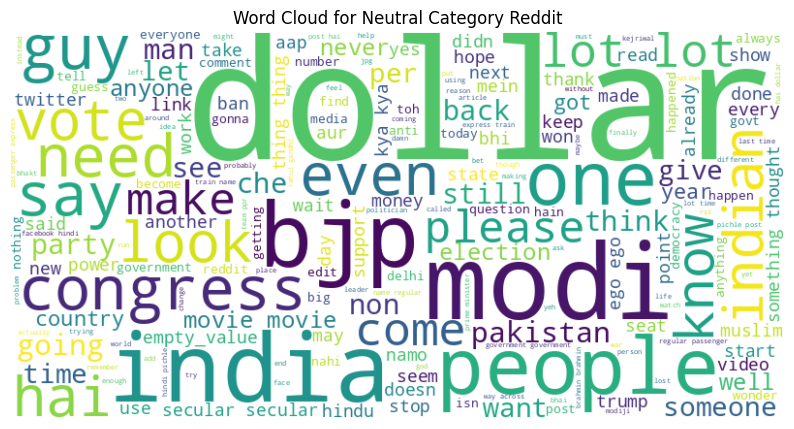

In [ ]:
# Creating wordcloud for each category
categories = reddit_full['category'].unique()
for category in categories:
    text = " ".join(reddit_full[reddit_full['category'] == category]['clean_text'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for {category} Category Reddit')
    plt.axis("off")
    plt.show()

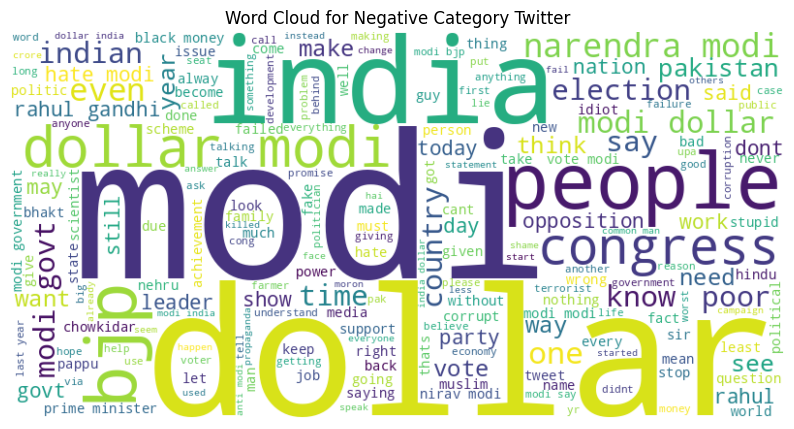

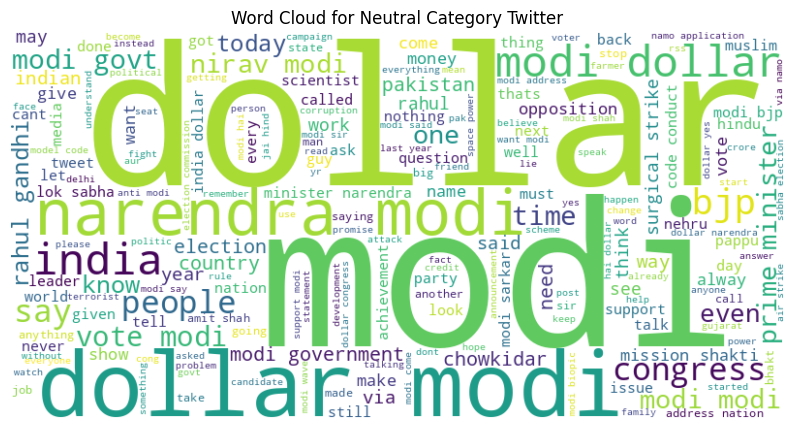

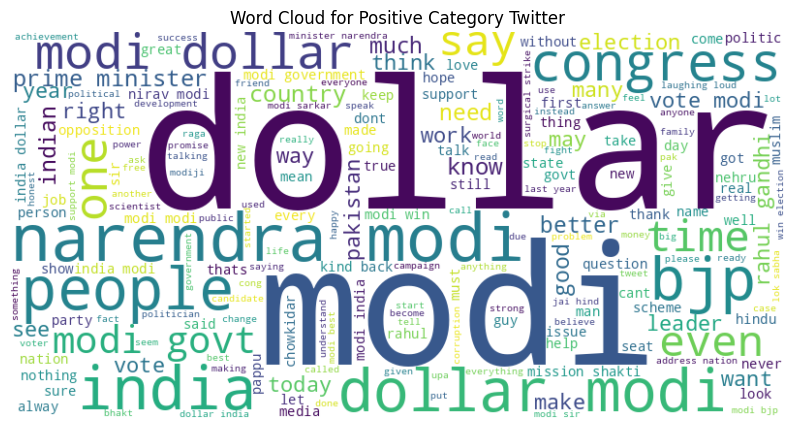

In [ ]:
# Creating wordcloud for each category
categories = twitter_full['category'].unique()
for category in categories:
    text = " ".join(twitter_full[twitter_full['category'] == category]['clean_text'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for {category} Category Twitter')
    plt.axis("off")
    plt.show()

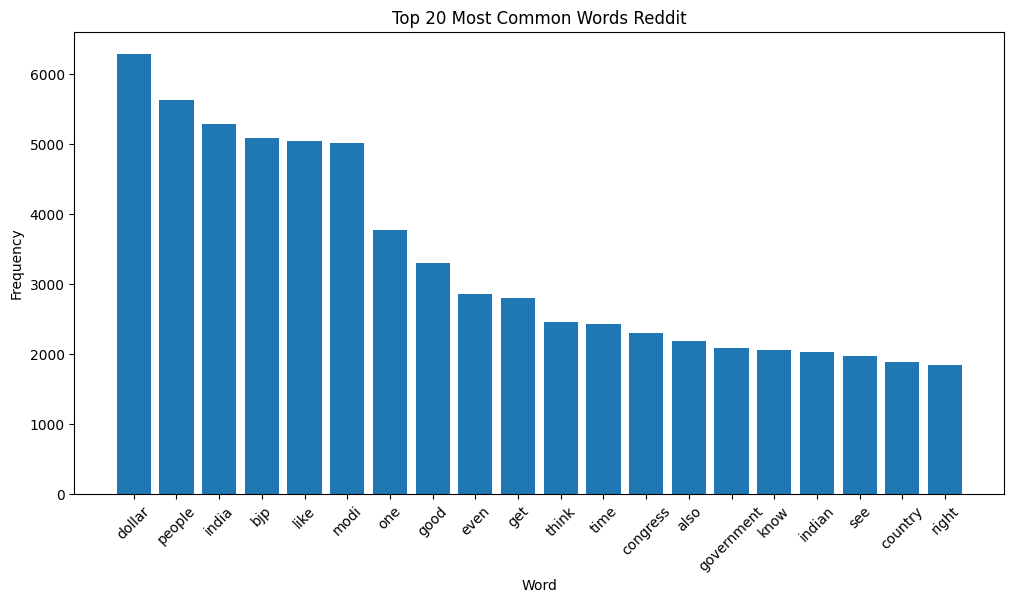

In [ ]:
# Calculating Word Frequency
all_text = " ".join(reddit_full['clean_text'])
words = all_text.split()
word_counts = Counter(words)
stopwords = set(STOPWORDS)
top_words = word_counts.most_common(20)
plt.figure(figsize=(12, 6))
plt.bar(*zip(*top_words))
plt.title('Top 20 Most Common Words Reddit')
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

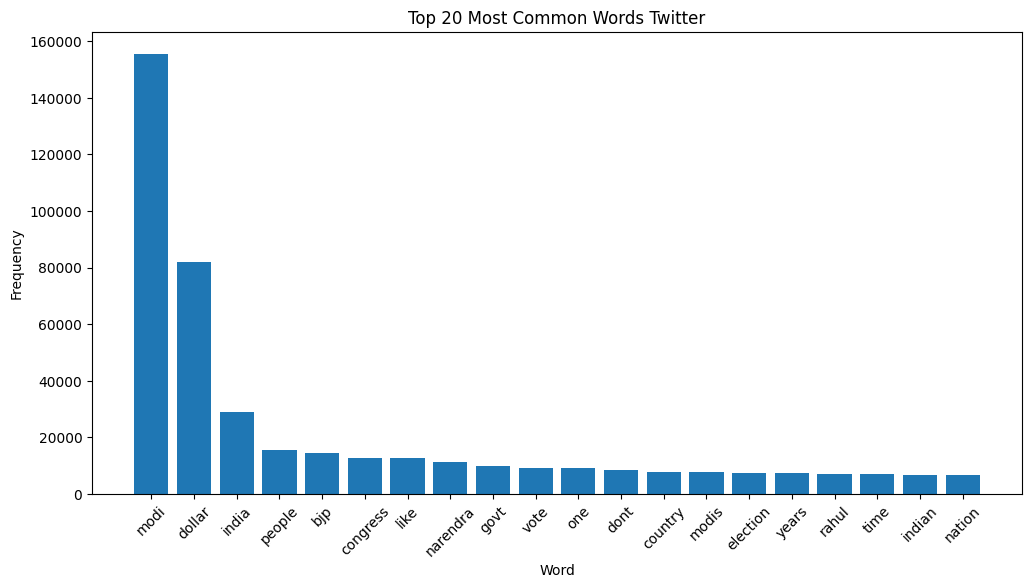

In [ ]:
# Calculating Word Frequency
all_text = " ".join(twitter_full['clean_text'])
words = all_text.split()
word_counts = Counter(words)
stopwords = set(STOPWORDS)
top_words = word_counts.most_common(20)
plt.figure(figsize=(12, 6))
plt.bar(*zip(*top_words))
plt.title('Top 20 Most Common Words Twitter')
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

<font size = 15, color = yellow> Data Preprocessing

In [ ]:
#train_test_split for reddit

X_train_reddit, X_test_reddit, y_train_reddit, y_test_reddit = train_test_split(reddit_full['clean_text'], reddit_full['category'], test_size=0.2, random_state=42)

#train_test_split for twitter

X_train_twitter, X_test_twitter, y_train_twitter, y_test_twitter = train_test_split(twitter_full['clean_text'], twitter_full['category'], test_size=0.2, random_state=42)


In [ ]:
# Encoding the target labels for reddit
label_encoder = LabelEncoder()
y_train_reddit = label_encoder.fit_transform(y_train_reddit)
y_test_reddit = label_encoder.transform(y_test_reddit)
# Checking the mapping
class_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Class Mapping:")
for class_label, encoded_value in class_mapping.items():
    print(f"{class_label}: {encoded_value}")

Class Mapping:
Negative: 0
Neutral: 1
Positive: 2


In [ ]:
# Encoding the target labels for twitter
label_encoder = LabelEncoder()
y_train_twitter = label_encoder.fit_transform(y_train_twitter)
y_test_twitter = label_encoder.transform(y_test_twitter)
# Checking the mapping
class_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Class Mapping:")
for class_label, encoded_value in class_mapping.items():
    print(f"{class_label}: {encoded_value}")

Class Mapping:
Negative: 0
Neutral: 1
Positive: 2


In [ ]:
X_train_reddit

29970    expected fallout govt hindu nationalist roots ...
16171                                        expected guru
28999    pakistan federal information minister said pak...
4119     article summary field trials crops formally ha...
29383    congress others plus media even decent jobs cu...
                               ...                        
16850                       afternoon magathread even noon
6265     india achieve around growth rate sensex fall w...
11284    except sure like lot way across way across way...
860                criticism aap aap modi congress fanbois
15795    people keep forgetting india still rd world co...
Name: clean_text, Length: 29619, dtype: object

In [ ]:
# Tokenizing and padding the text data for Reddit
max_words = 15000
max_sequence_length = 500
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train_reddit)

X_train_reddit_sequence = tokenizer.texts_to_sequences(X_train_reddit)
X_test_reddit_sequence = tokenizer.texts_to_sequences(X_test_reddit)

X_train_reddit_padded = tf.keras.preprocessing.sequence.pad_sequences(X_train_reddit_sequence, maxlen=max_sequence_length)
X_test_reddit_padded = tf.keras.preprocessing.sequence.pad_sequences(X_test_reddit_sequence, maxlen=max_sequence_length)
# Saving the tokenizer for future use
tokenizer_filename = 'tokenizer.pkl'
with open(tokenizer_filename, 'wb') as tokenizer_file:
    pickle.dump(tokenizer, tokenizer_file)

In [ ]:
# Tokenizing and padding the text data for Twitter
max_words = 15000
max_sequence_length = 500
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train_twitter)

X_train_twitter_sequence = tokenizer.texts_to_sequences(X_train_twitter)
X_test_twitter_sequence = tokenizer.texts_to_sequences(X_test_twitter)

X_train_twitter_padded = tf.keras.preprocessing.sequence.pad_sequences(X_train_twitter_sequence, maxlen=max_sequence_length)
X_test_twitter_padded = tf.keras.preprocessing.sequence.pad_sequences(X_test_twitter_sequence, maxlen=max_sequence_length)
# Saving the tokenizer for future use
tokenizer_filename = 'tokenizer.pkl'
with open(tokenizer_filename, 'wb') as tokenizer_file:
    pickle.dump(tokenizer, tokenizer_file)

In [ ]:
sentences_reddit = [row.split() for row in reddit_full['clean_text']]
model_w2v_reddit = Word2Vec(sentences_reddit, vector_size=100, window=2, min_count=1, workers=4)
embedding_matrix_reddit = np.zeros((max_words, model_w2v_reddit.vector_size))
for i, word in enumerate(model_w2v_reddit.wv.index_to_key[:max_words-1]):
    embedding_vector_reddit = model_w2v_reddit.wv[word]
    if embedding_vector_reddit is not None:
        embedding_matrix_reddit[i+1] = embedding_vector_reddit

In [ ]:
sentences_twitter = [row.split() for row in twitter_full['clean_text']]
model_w2v_twitter = Word2Vec(sentences_twitter, vector_size=100, window=2, min_count=1, workers=4)
embedding_matrix_twitter = np.zeros((max_words, model_w2v_twitter.vector_size))
for i, word in enumerate(model_w2v_twitter.wv.index_to_key[:max_words-1]):
    embedding_vector_twitter = model_w2v_twitter.wv[word]
    if embedding_vector_twitter is not None:
        embedding_matrix_twitter[i+1] = embedding_vector_twitter

<font size = 15, color = yellow> Building the Model

In [ ]:
# Hyperparameters
embedding_dim = 100
batch_size = 64
epochs = 30
# Building the LSTM model
with strategy.scope():
  model = Sequential()
  model.add(Embedding(max_words, embedding_dim, input_length=max_sequence_length, weights=[embedding_matrix_reddit]))
  model.add(LSTM(200))
  model.add(Dropout(0.3))
  model.add(Dense(3, activation='softmax'))
# Compiling & training
  model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
  model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 500, 100)          1500000   
                                                                 
 lstm_6 (LSTM)               (None, 200)               240800    
                                                                 
 dropout_6 (Dropout)         (None, 200)               0         
                                                                 
 dense_6 (Dense)             (None, 3)                 603       
                                                                 
Total params: 1,741,403
Trainable params: 1,741,403
Non-trainable params: 0
_________________________________________________________________


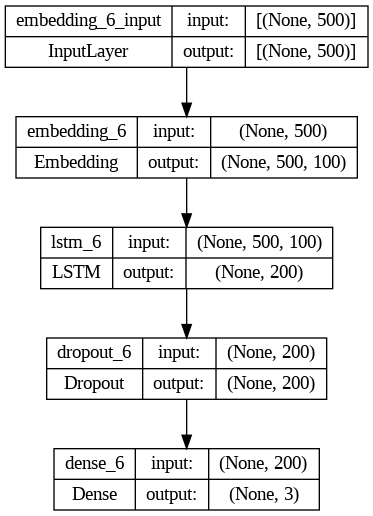

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
history = model.fit(X_train_reddit_padded, y_train_reddit, batch_size=batch_size, epochs=epochs, validation_split=0.1, callbacks=[early_stopping])
# Evaluation on Test data
test_loss, test_accuracy = model.evaluate(X_test_reddit_padded, y_test_reddit, verbose=1)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')
# Predictions on Test data
y_test_pred_reddit = model.predict(X_test_reddit_padded)
y_test_pred_classes_reddit = np.argmax(y_test_pred_reddit, axis=1)
# Calculate additional metrics
f1 = f1_score(y_test_reddit, y_test_pred_classes_reddit, average='weighted')
precision = precision_score(y_test_reddit, y_test_pred_classes_reddit, average='weighted')
recall = recall_score(y_test_reddit, y_test_pred_classes_reddit, average='weighted')
print(f'F1 Score: {f1:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')

Epoch 1/30
417/417 [==============================] - 43s 90ms/step - loss: 0.7862 - accuracy: 0.6489 - val_loss: 0.5719 - val_accuracy: 0.7532
Epoch 2/30
417/417 [==============================] - 33s 80ms/step - loss: 0.3867 - accuracy: 0.8618 - val_loss: 0.3802 - val_accuracy: 0.8666
Epoch 3/30
417/417 [==============================] - 32s 78ms/step - loss: 0.2094 - accuracy: 0.9336 - val_loss: 0.4427 - val_accuracy: 0.8599
Epoch 4/30
417/417 [==============================] - 33s 78ms/step - loss: 0.1372 - accuracy: 0.9595 - val_loss: 0.5489 - val_accuracy: 0.8521
Epoch 5/30
232/232 [==============================] - 8s 31ms/step - loss: 0.4048 - accuracy: 0.8579
Test Loss: 0.4048
Test Accuracy: 0.8579
232/232 [==============================] - 7s 25ms/step
F1 Score: 0.8547
Precision: 0.8571
Recall: 0.8579


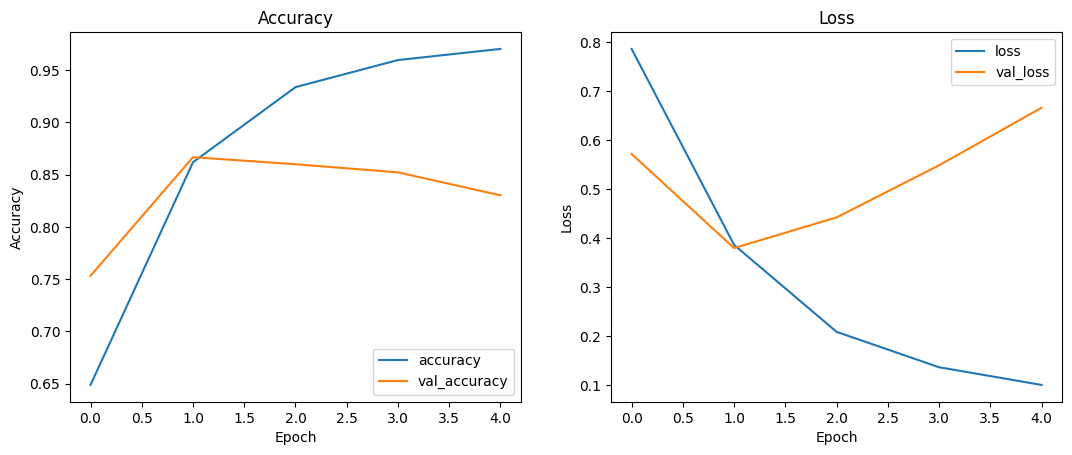

In [ ]:
# Plotting training and testing curves
default_size = plt.rcParams['figure.figsize']
fig = plt.figure(figsize=[default_size[0] * 2, default_size[1]])

fig.add_subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label = 'accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.legend(loc='lower right')

fig.add_subplot(1, 2, 2)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend(loc='upper right')
plt.show()

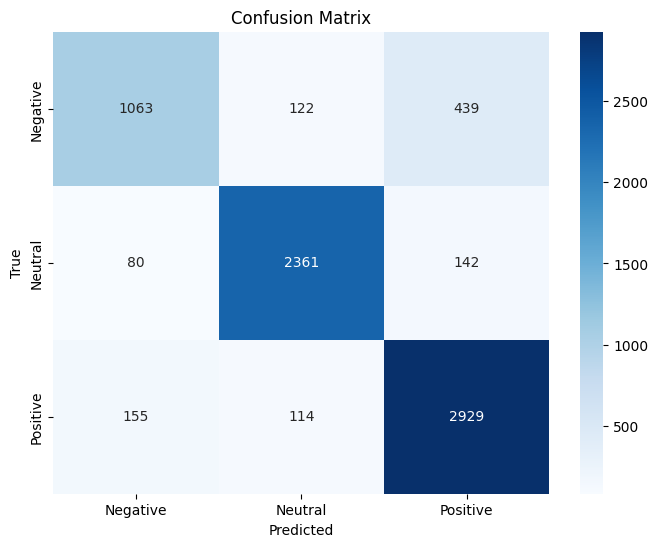

In [ ]:
# Confusion Matrix
conf_mat = confusion_matrix(y_test_reddit, y_test_pred_classes_reddit)
xlabels = ['Negative', 'Neutral', 'Positive']

# Plotting Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=xlabels, yticklabels=xlabels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
vocab_size = 15000
embedding_dim = 100
batch_size = 64
epochs = 30
learning_rate = 0.1
decay_rate = learning_rate / epochs
momentum = 0.8

sgd = SGD(lr=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)

with strategy.scope():
  model_V2 = Sequential()
  model_V2.add(Embedding(max_words, embedding_dim, input_length=max_sequence_length, weights=[embedding_matrix_reddit]))
  model_V2.add(Conv1D(filters=128, kernel_size=3, padding='same', activation='relu'))
  model_V2.add(MaxPooling1D(pool_size=2))
  model_V2.add(Bidirectional(LSTM(256)))
  model_V2.add(Dropout(0.4))
  model_V2.add(Dense(3, activation='softmax'))
  model_V2.compile(loss='sparse_categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
  model_V2.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 500, 100)          1500000   
                                                                 
 conv1d_5 (Conv1D)           (None, 500, 128)          38528     
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 250, 128)         0         
 1D)                                                             
                                                                 
 bidirectional_5 (Bidirectio  (None, 512)              788480    
 nal)                                                            
                                                                 
 dropout_10 (Dropout)        (None, 512)               0         
                                                                 
 dense_10 (Dense)            (None, 3)               

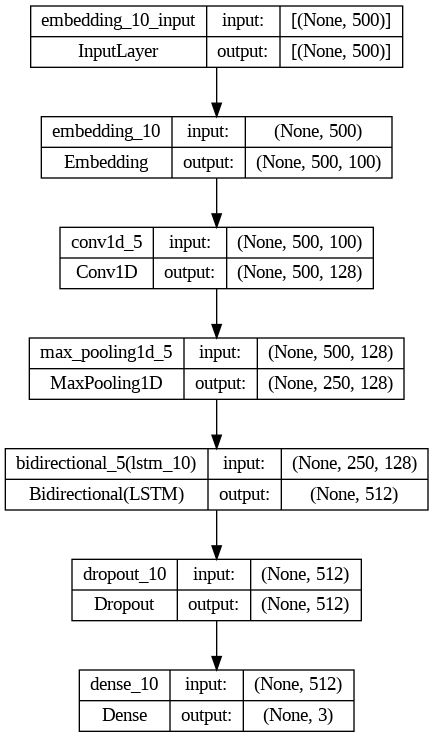

In [ ]:
tf.keras.utils.plot_model(model_V2, show_shapes=True)

In [ ]:
history_V2 = model_V2.fit(X_train_reddit_padded, y_train_reddit, batch_size=batch_size, epochs=epochs, validation_split=0.1, callbacks=[early_stopping])
# Evaluation on Test data
test_loss, test_accuracy = model_V2.evaluate(X_test_reddit_padded, y_test_reddit, verbose=1)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')
# Predictions on Test data
y_test_pred_reddit = model_V2.predict(X_test_reddit_padded)
y_test_pred_classes_reddit = np.argmax(y_test_pred_reddit, axis=1)
# Calculate additional metrics
f1 = f1_score(y_test_reddit, y_test_pred_classes_reddit, average='weighted')
precision = precision_score(y_test_reddit, y_test_pred_classes_reddit, average='weighted')
recall = recall_score(y_test_reddit, y_test_pred_classes_reddit, average='weighted')
print(f'F1 Score: {f1:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')

Epoch 1/30
417/417 [==============================] - 45s 82ms/step - loss: 0.8983 - accuracy: 0.5826 - val_loss: 0.8604 - val_accuracy: 0.5935
Epoch 2/30
417/417 [==============================] - 28s 68ms/step - loss: 0.8550 - accuracy: 0.6004 - val_loss: 0.8354 - val_accuracy: 0.6215
Epoch 3/30
417/417 [==============================] - 29s 68ms/step - loss: 0.8254 - accuracy: 0.6178 - val_loss: 0.8047 - val_accuracy: 0.6411
Epoch 4/30
417/417 [==============================] - 28s 67ms/step - loss: 0.8000 - accuracy: 0.6367 - val_loss: 0.7753 - val_accuracy: 0.6540
Epoch 5/30
417/417 [==============================] - 28s 68ms/step - loss: 0.7719 - accuracy: 0.6522 - val_loss: 0.7565 - val_accuracy: 0.6624
Epoch 6/30
417/417 [==============================] - 28s 68ms/step - loss: 0.7473 - accuracy: 0.6657 - val_loss: 0.7600 - val_accuracy: 0.6560
Epoch 7/30
417/417 [==============================] - 28s 68ms/step - loss: 0.7240 - accuracy: 0.6769 - val_loss: 0.7334 - val_accuracy:

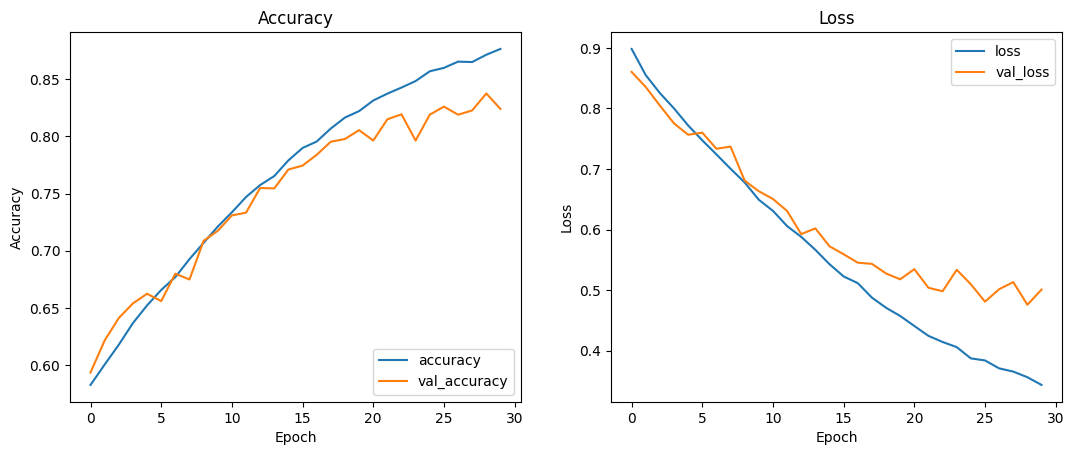

In [ ]:
# Plotting training and testing curves
default_size = plt.rcParams['figure.figsize']
fig = plt.figure(figsize=[default_size[0] * 2, default_size[1]])

fig.add_subplot(1, 2, 1)
plt.plot(history_V2.history['accuracy'], label = 'accuracy')
plt.plot(history_V2.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.legend(loc='lower right')

fig.add_subplot(1, 2, 2)
plt.plot(history_V2.history['loss'], label='loss')
plt.plot(history_V2.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend(loc='upper right')
plt.show()

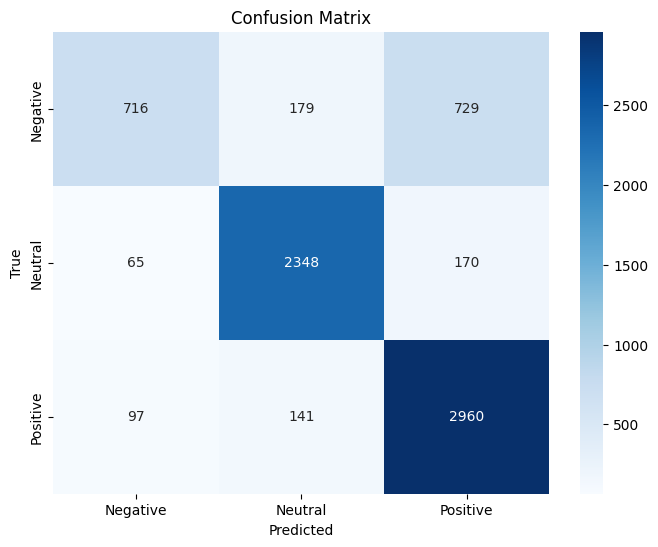

In [ ]:
# Confusion Matrix
conf_mat = confusion_matrix(y_test_reddit, y_test_pred_classes_reddit)
xlabels = ['Negative', 'Neutral', 'Positive']

# Plotting Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=xlabels, yticklabels=xlabels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

<font size = 15, color = yellow> Twitter


In [ ]:
# Hyperparameters
embedding_dim = 100
batch_size = 64
epochs = 30
# Building the LSTM model
with strategy.scope():
  model_twitter = Sequential()
  model_twitter.add(Embedding(max_words, embedding_dim, input_length=max_sequence_length, weights=[embedding_matrix_twitter]))
  model_twitter.add(LSTM(200))
  model_twitter.add(Dropout(0.5))
  model_twitter.add(Dense(3, activation='softmax'))
# Compiling & training
  model_twitter.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  model_twitter.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, 500, 100)          1500000   
                                                                 
 lstm_11 (LSTM)              (None, 200)               240800    
                                                                 
 dropout_11 (Dropout)        (None, 200)               0         
                                                                 
 dense_11 (Dense)            (None, 3)                 603       
                                                                 
Total params: 1,741,403
Trainable params: 1,741,403
Non-trainable params: 0
_________________________________________________________________


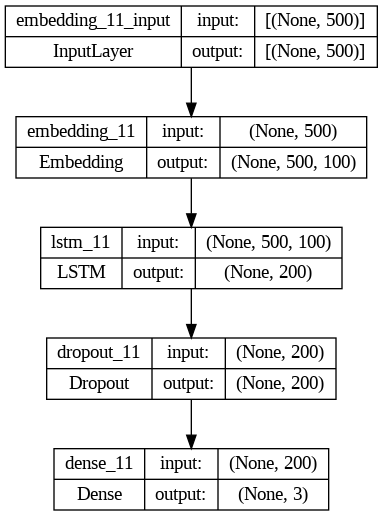

In [ ]:
tf.keras.utils.plot_model(model_twitter, show_shapes=True)

In [ ]:
history_twitter = model_twitter.fit(X_train_twitter_padded, y_train_twitter, batch_size=batch_size, epochs=epochs, validation_split=0.1, callbacks=[early_stopping])


Epoch 1/30
1834/1834 [==============================] - 152s 79ms/step - loss: 0.4995 - accuracy: 0.8080 - val_loss: 0.2827 - val_accuracy: 0.9181
Epoch 2/30
1834/1834 [==============================] - 140s 76ms/step - loss: 0.2590 - accuracy: 0.9235 - val_loss: 0.2714 - val_accuracy: 0.9218
Epoch 3/30
1834/1834 [==============================] - 140s 76ms/step - loss: 0.2233 - accuracy: 0.9333 - val_loss: 0.2857 - val_accuracy: 0.9136
Epoch 4/30
1834/1834 [==============================] - 140s 76ms/step - loss: 0.1961 - accuracy: 0.9398 - val_loss: 0.2932 - val_accuracy: 0.9146
Epoch 5/30
1834/1834 [==============================] - 140s 76ms/step - loss: 0.1689 - accuracy: 0.9472 - val_loss: 0.3378 - val_accuracy: 0.9044


In [ ]:
# Evaluation on Test data
test_loss, test_accuracy = model_twitter.evaluate(X_test_twitter_padded, y_test_twitter, verbose=1)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')
# Predictions on Test data
y_test_pred_twitter = model_twitter.predict(X_test_twitter_padded)
y_test_pred_classes_twitter = np.argmax(y_test_pred_twitter, axis=1)
# Calculate additional metrics
f1 = f1_score(y_test_twitter, y_test_pred_classes_twitter, average='weighted')
precision = precision_score(y_test_twitter, y_test_pred_classes_twitter, average='weighted')
recall = recall_score(y_test_twitter, y_test_pred_classes_twitter, average='weighted')
print(f'F1 Score: {f1:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')

1019/1019 [==============================] - 28s 26ms/step - loss: 0.2757 - accuracy: 0.9185
Test Loss: 0.2757
Test Accuracy: 0.9185
1019/1019 [==============================] - 23s 21ms/step
F1 Score: 0.9186
Precision: 0.9197
Recall: 0.9185


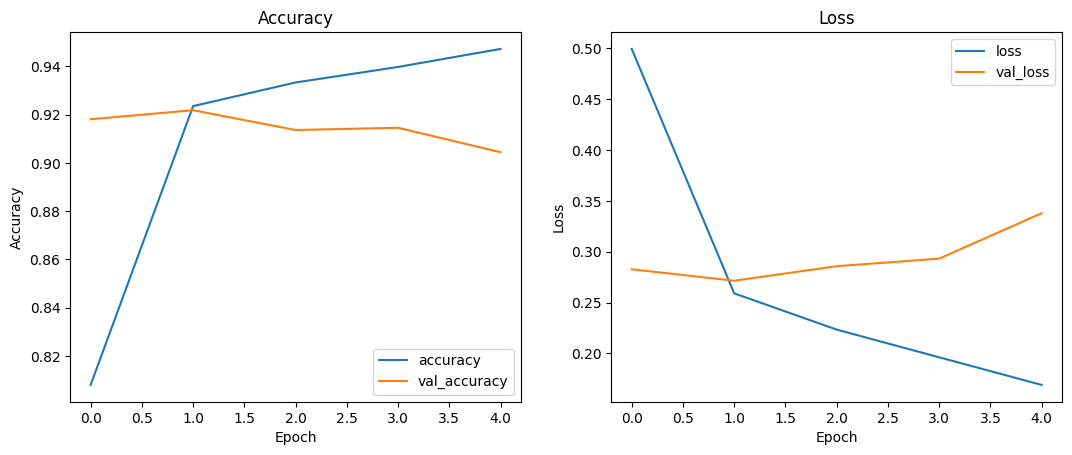

In [ ]:
# Plotting training and testing curves
default_size = plt.rcParams['figure.figsize']
fig = plt.figure(figsize=[default_size[0] * 2, default_size[1]])

fig.add_subplot(1, 2, 1)
plt.plot(history_twitter.history['accuracy'], label = 'accuracy')
plt.plot(history_twitter.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.legend(loc='lower right')

fig.add_subplot(1, 2, 2)
plt.plot(history_twitter.history['loss'], label='loss')
plt.plot(history_twitter.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend(loc='upper right')
plt.show()

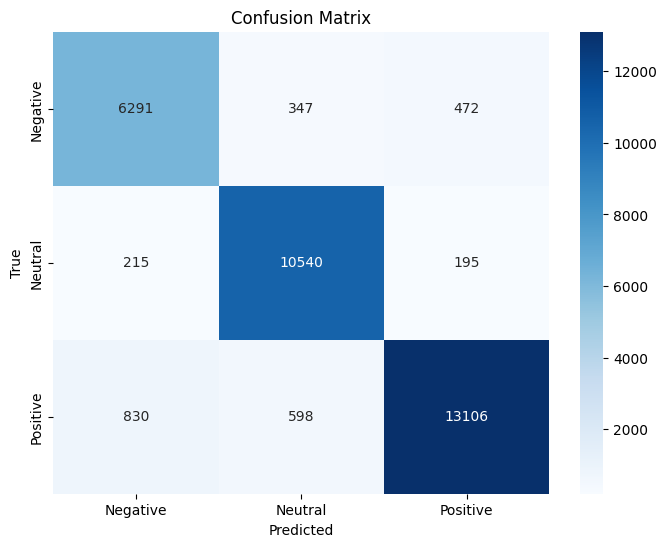

In [ ]:
# Confusion Matrix
conf_mat = confusion_matrix(y_test_twitter, y_test_pred_classes_twitter)
xlabels = ['Negative', 'Neutral', 'Positive']

# Plotting Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=xlabels, yticklabels=xlabels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
vocab_size = 10000
embedding_dim = 100
batch_size = 64
epochs = 30
learning_rate = 0.1
decay_rate = learning_rate / epochs
momentum = 0.8

sgd = SGD(lr=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)

with strategy.scope():
  model_twitter_V2 = Sequential()
  model_twitter_V2.add(Embedding(max_words, embedding_dim, input_length=max_sequence_length, weights=[embedding_matrix_twitter]))
  model_twitter_V2.add(Conv1D(filters=128, kernel_size=3, padding='same', activation='relu'))
  model_twitter_V2.add(MaxPooling1D(pool_size=2))
  model_twitter_V2.add(Bidirectional(LSTM(256)))
  model_twitter_V2.add(Dropout(0.4))
  model_twitter_V2.add(Dense(3, activation='softmax'))
  model_twitter_V2.compile(loss='sparse_categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
  model_twitter_V2.summary()

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_12 (Embedding)    (None, 500, 100)          1500000   
                                                                 
 conv1d_6 (Conv1D)           (None, 500, 128)          38528     
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 250, 128)         0         
 1D)                                                             
                                                                 
 bidirectional_6 (Bidirectio  (None, 512)              788480    
 nal)                                                            
                                                                 
 dropout_12 (Dropout)        (None, 512)               0         
                                                                 
 dense_12 (Dense)            (None, 3)               

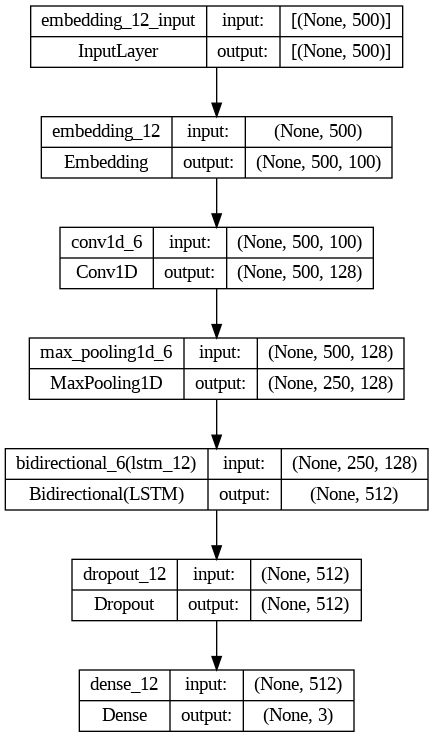

In [ ]:
tf.keras.utils.plot_model(model_twitter_V2, show_shapes=True)

In [ ]:
history_twitter_V2 = model_twitter_V2.fit(X_train_twitter_padded, y_train_twitter, batch_size=batch_size, epochs=epochs, validation_split=0.1, callbacks=[early_stopping])
# Evaluation on Test data
test_loss, test_accuracy = model_twitter_V2.evaluate(X_test_twitter_padded, y_test_twitter, verbose=1)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')
# Predictions on Test data
y_test_pred_twitter = model_twitter_V2.predict(X_test_twitter_padded)
y_test_pred_classes_twitter = np.argmax(y_test_pred_twitter, axis=1)
# Calculate additional metrics
f1 = f1_score(y_test_twitter, y_test_pred_classes_twitter, average='weighted')
precision = precision_score(y_test_twitter, y_test_pred_classes_twitter, average='weighted')
recall = recall_score(y_test_twitter, y_test_pred_classes_twitter, average='weighted')
print(f'F1 Score: {f1:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')

Epoch 1/30
1834/1834 [==============================] - 137s 69ms/step - loss: 0.8065 - accuracy: 0.6395 - val_loss: 0.7520 - val_accuracy: 0.6676
Epoch 2/30
1834/1834 [==============================] - 122s 66ms/step - loss: 0.6742 - accuracy: 0.7193 - val_loss: 0.6569 - val_accuracy: 0.7279
Epoch 3/30
1834/1834 [==============================] - 122s 67ms/step - loss: 0.6303 - accuracy: 0.7452 - val_loss: 0.6399 - val_accuracy: 0.7386
Epoch 4/30
1834/1834 [==============================] - 122s 66ms/step - loss: 0.6039 - accuracy: 0.7580 - val_loss: 0.6327 - val_accuracy: 0.7408
Epoch 5/30
1834/1834 [==============================] - 122s 67ms/step - loss: 0.5850 - accuracy: 0.7687 - val_loss: 0.6251 - val_accuracy: 0.7444
Epoch 6/30
1834/1834 [==============================] - 122s 67ms/step - loss: 0.5706 - accuracy: 0.7757 - val_loss: 0.6163 - val_accuracy: 0.7533
Epoch 7/30
1834/1834 [==============================] - 121s 66ms/step - loss: 0.5590 - accuracy: 0.7822 - val_loss: 0

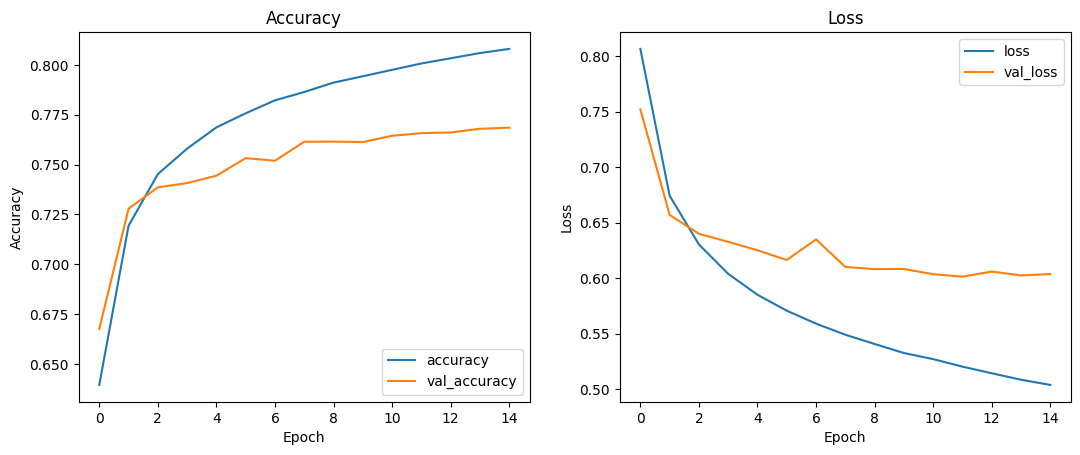

In [ ]:
# Plotting training and testing curves
default_size = plt.rcParams['figure.figsize']
fig = plt.figure(figsize=[default_size[0] * 2, default_size[1]])

fig.add_subplot(1, 2, 1)
plt.plot(history_twitter_V2.history['accuracy'], label = 'accuracy')
plt.plot(history_twitter_V2.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.legend(loc='lower right')

fig.add_subplot(1, 2, 2)
plt.plot(history_twitter_V2.history['loss'], label='loss')
plt.plot(history_twitter_V2.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend(loc='upper right')
plt.show()

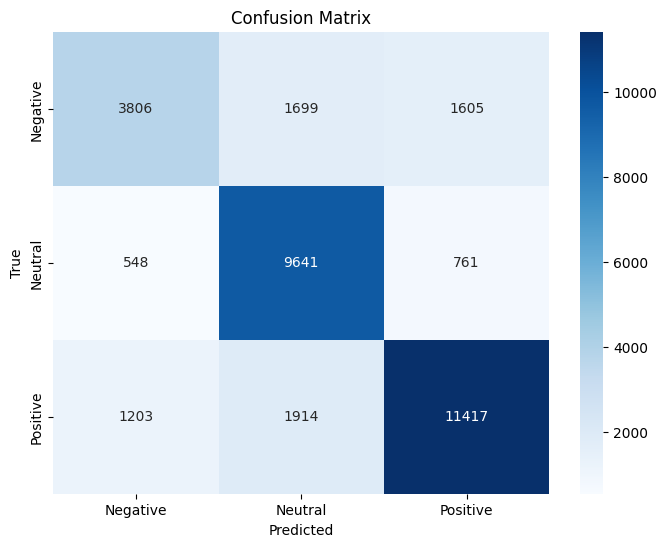

In [ ]:
# Confusion Matrix
conf_mat = confusion_matrix(y_test_twitter, y_test_pred_classes_twitter)
xlabels = ['Negative', 'Neutral', 'Positive']

# Plotting Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=xlabels, yticklabels=xlabels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

<font size=15, color= yellow> Reddit + twitter dataset

In [ ]:
reddit_full = "/content/drive/MyDrive/UMD-2023-Fall/MSML-651/Final Project/Dataset/databricks data/reddit_token_filtered.csv"
twitter_full = "/content/drive/MyDrive/UMD-2023-Fall/MSML-651/Final Project/Dataset/databricks data/twitter_token_filtered.csv"

In [ ]:
reddit_full = pd.read_csv(reddit_full)
twitter_full = pd.read_csv(twitter_full)

In [ ]:
data = pd.concat([reddit_full,twitter_full],ignore_index = True)

In [ ]:
# Renaming the category for meaningful insights
mapping = {0: 'Neutral', 1: 'Positive', -1: 'Negative'}
data['category'] = data['category'].map(mapping)
data.head()

clean_text  category
0  family mormon never tried explain still stare ...  Positive
1  buddhism much lot compatible christianity espe...  Positive
2  seriously say thing first won get complex expl...  Negative
3  learned want teach different focus goal wrappi...   Neutral
4  benefit may want read living buddha living chr...  Positive

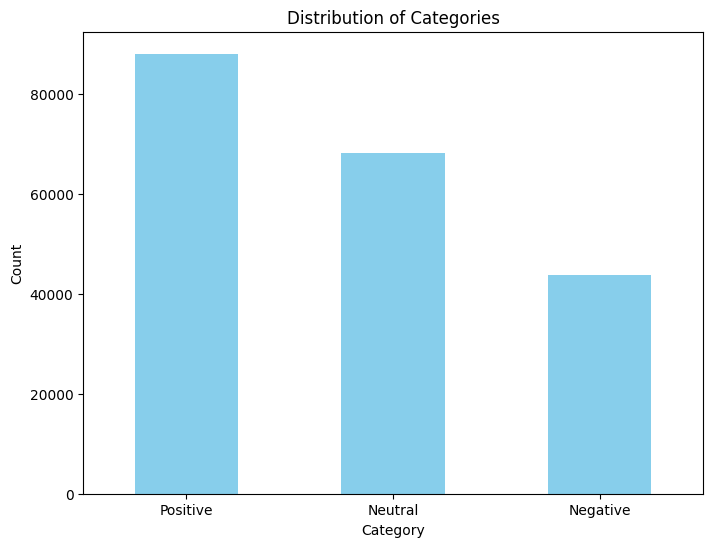

In [ ]:
# Checking the distribution of categories
category_counts = data['category'].value_counts()
plt.figure(figsize=(8, 6))
category_counts.plot(kind='bar', color='skyblue')
plt.title('Distribution of Categories')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

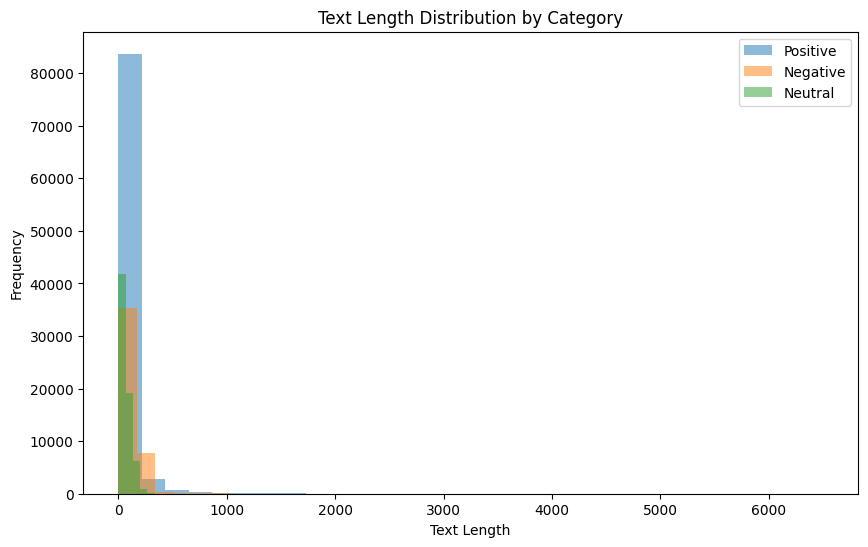

In [ ]:
# Performing Text Length Analysis
data['text_length'] = data['clean_text'].apply(len)
plt.figure(figsize=(10, 6))
for category in data['category'].unique():
    subset = data[data['category'] == category]
    plt.hist(subset['text_length'], bins=30, alpha=0.5, label=category)
plt.title('Text Length Distribution by Category')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.legend()
plt.show()

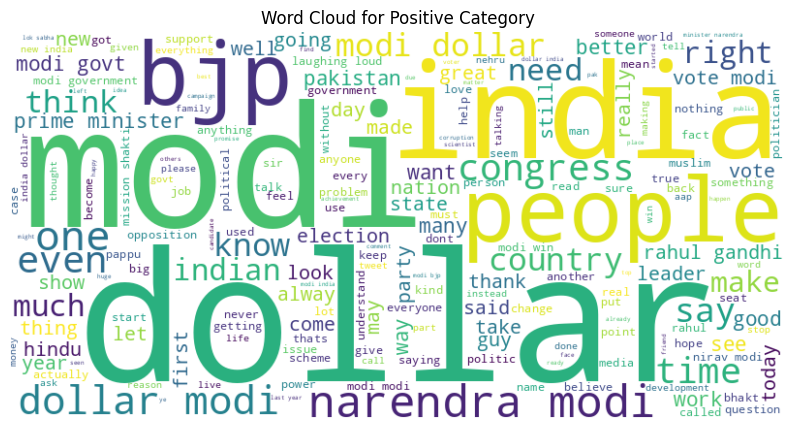

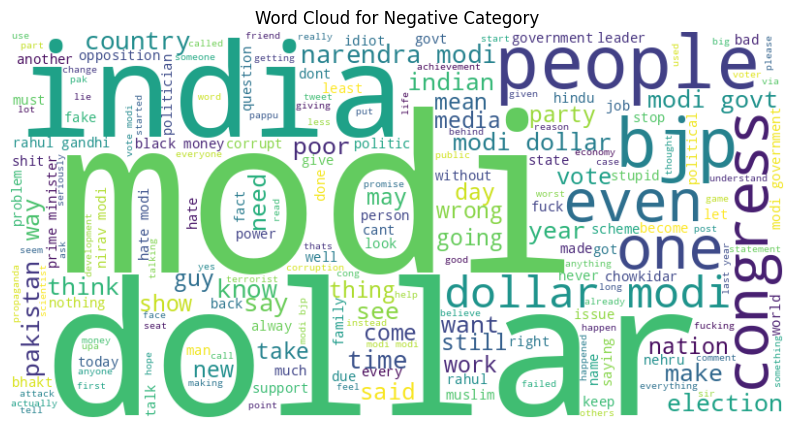

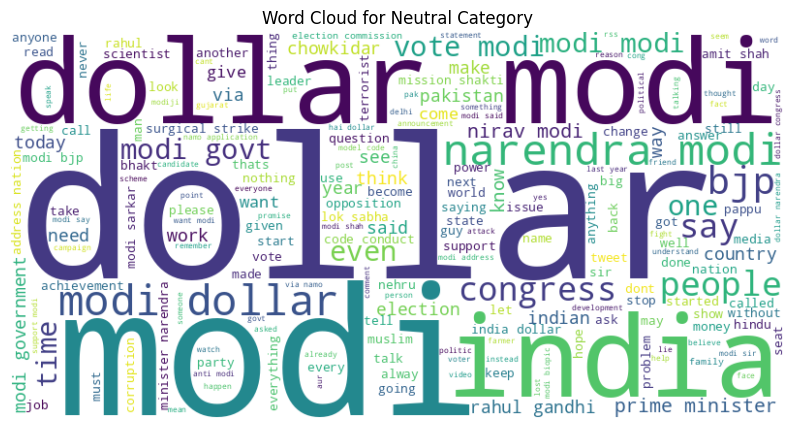

In [ ]:
# Creating wordcloud for each category
categories = data['category'].unique()
for category in categories:
    text = " ".join(data[data['category'] == category]['clean_text'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for {category} Category')
    plt.axis("off")
    plt.show()

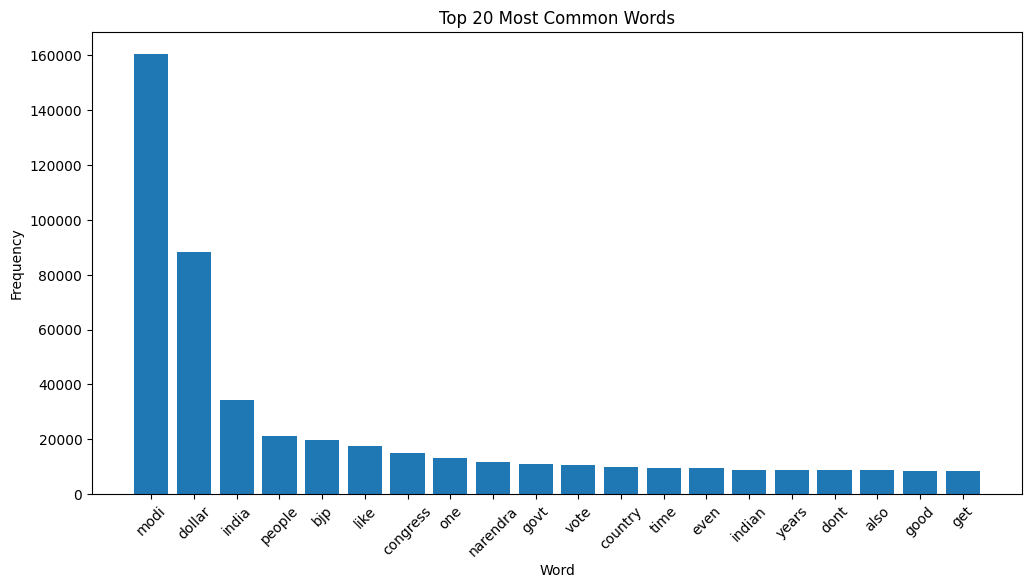

In [ ]:
# Calculating Word Frequency
all_text = " ".join(data['clean_text'])
words = all_text.split()
word_counts = Counter(words)
stopwords = set(STOPWORDS)
top_words = word_counts.most_common(20)
plt.figure(figsize=(12, 6))
plt.bar(*zip(*top_words))
plt.title('Top 20 Most Common Words')
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

In [ ]:
# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data['clean_text'], data['category'], test_size=0.2, random_state=42)

In [ ]:
# Encoding the target labels
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)
# Checking the mapping
class_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Class Mapping:")
for class_label, encoded_value in class_mapping.items():
    print(f"{class_label}: {encoded_value}")

Class Mapping:
Negative: 0
Neutral: 1
Positive: 2


In [ ]:
# Tokenizing and padding the text data
max_words = 15000
max_sequence_length = 500
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)
X_train_sequence = tokenizer.texts_to_sequences(X_train)
X_test_sequence = tokenizer.texts_to_sequences(X_test)
X_train_padded = tf.keras.preprocessing.sequence.pad_sequences(X_train_sequence, maxlen=max_sequence_length)
X_test_padded = tf.keras.preprocessing.sequence.pad_sequences(X_test_sequence, maxlen=max_sequence_length)
# Saving the tokenizer for future use
tokenizer_filename = 'tokenizer.pkl'
with open(tokenizer_filename, 'wb') as tokenizer_file:
    pickle.dump(tokenizer, tokenizer_file)

In [ ]:
sentences_df = [row.split() for row in data['clean_text']]
model_w2v_df = Word2Vec(sentences_df, vector_size=100, window=2, min_count=1, workers=4)
embedding_matrix_df = np.zeros((max_words, model_w2v_df.vector_size))
for i, word in enumerate(model_w2v_df.wv.index_to_key[:max_words-1]):
    embedding_vector_df = model_w2v_df.wv[word]
    if embedding_vector_df is not None:
        embedding_matrix_df[i+1] = embedding_vector_df

In [ ]:
# Hyperparameters
embedding_dim = 100
batch_size = 64
epochs = 30
# Building the LSTM model
with strategy.scope():
  model_tr = Sequential()
  model_tr.add(Embedding(max_words, embedding_dim, input_length=max_sequence_length, weights=[embedding_matrix_df]))
  model_tr.add(LSTM(200))
  model_tr.add(Dropout(0.5))
  model_tr.add(Dense(3, activation='softmax'))
# Compiling & training
  model_tr.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  model_tr.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_13 (Embedding)    (None, 500, 100)          1500000   
                                                                 
 lstm_13 (LSTM)              (None, 200)               240800    
                                                                 
 dropout_13 (Dropout)        (None, 200)               0         
                                                                 
 dense_13 (Dense)            (None, 3)                 603       
                                                                 
Total params: 1,741,403
Trainable params: 1,741,403
Non-trainable params: 0
_________________________________________________________________


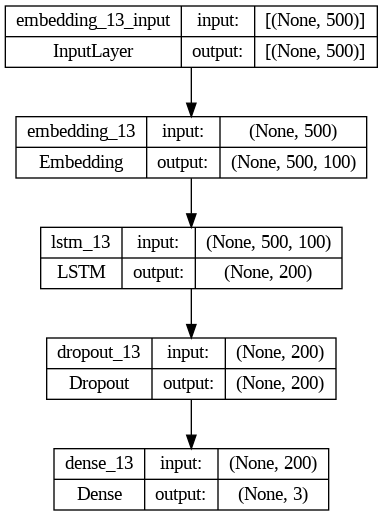

In [ ]:
tf.keras.utils.plot_model(model_tr, show_shapes=True)

In [ ]:
history_tr = model_tr.fit(X_train_padded, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1, callbacks=[early_stopping])
# Evaluation on Test data
test_loss, test_accuracy = model_tr.evaluate(X_test_padded, y_test, verbose=1)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')
# Predictions on Test data
y_test_pred = model_tr.predict(X_test_padded)
y_test_pred_classes = np.argmax(y_test_pred, axis=1)
# Calculate additional metrics
f1 = f1_score(y_test, y_test_pred_classes, average='weighted')
precision = precision_score(y_test, y_test_pred_classes, average='weighted')
recall = recall_score(y_test, y_test_pred_classes, average='weighted')
print(f'F1 Score: {f1:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')

Epoch 1/30
2250/2250 [==============================] - 177s 76ms/step - loss: 0.4663 - accuracy: 0.8260 - val_loss: 0.2718 - val_accuracy: 0.9200
Epoch 2/30
2250/2250 [==============================] - 169s 75ms/step - loss: 0.2605 - accuracy: 0.9229 - val_loss: 0.2624 - val_accuracy: 0.9226
Epoch 3/30
2250/2250 [==============================] - 168s 75ms/step - loss: 0.2281 - accuracy: 0.9311 - val_loss: 0.2698 - val_accuracy: 0.9209
Epoch 4/30
2250/2250 [==============================] - 168s 75ms/step - loss: 0.2032 - accuracy: 0.9372 - val_loss: 0.2768 - val_accuracy: 0.9179
Epoch 5/30
1250/1250 [==============================] - 34s 26ms/step - loss: 0.2710 - accuracy: 0.9222
Test Loss: 0.2710
Test Accuracy: 0.9222
1250/1250 [==============================] - 27s 20ms/step
F1 Score: 0.9217
Precision: 0.9220
Recall: 0.9222


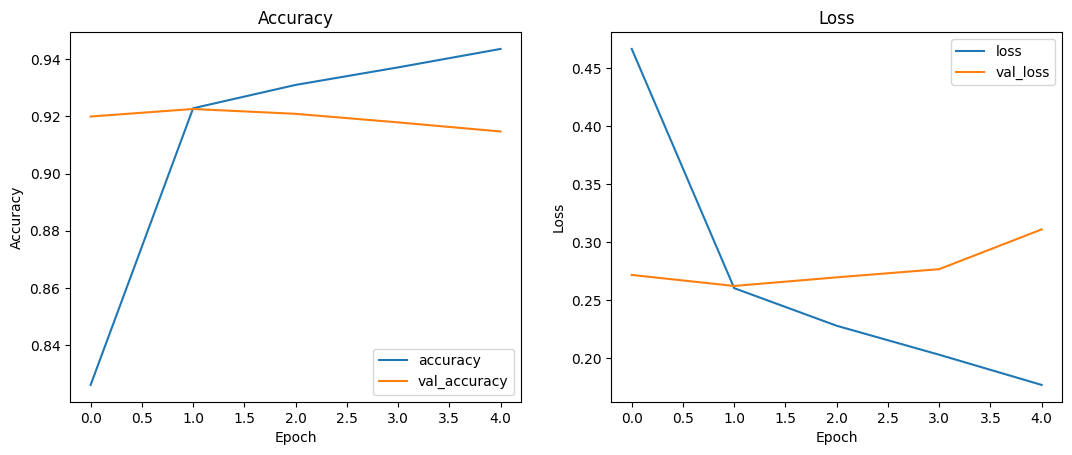

In [ ]:
# Plotting training and testing curves
default_size = plt.rcParams['figure.figsize']
fig = plt.figure(figsize=[default_size[0] * 2, default_size[1]])

fig.add_subplot(1, 2, 1)
plt.plot(history_tr.history['accuracy'], label = 'accuracy')
plt.plot(history_tr.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.legend(loc='lower right')

fig.add_subplot(1, 2, 2)
plt.plot(history_tr.history['loss'], label='loss')
plt.plot(history_tr.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend(loc='upper right')
plt.show()

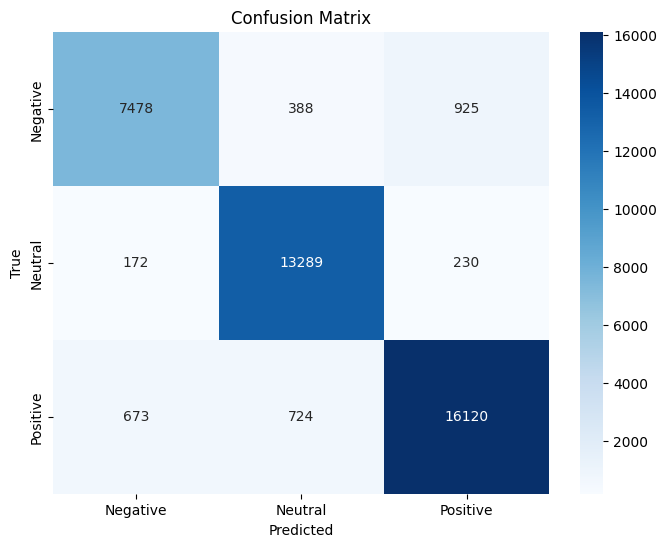

In [ ]:
# Confusion Matrix
conf_mat = confusion_matrix(y_test, y_test_pred_classes)
xlabels = ['Negative', 'Neutral', 'Positive']

# Plotting Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=xlabels, yticklabels=xlabels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
vocab_size = 15000
embedding_dim = 100
batch_size = 64
epochs = 30
learning_rate = 0.1
decay_rate = learning_rate / epochs
momentum = 0.8

sgd = SGD(lr=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)

with strategy.scope():
  model_tr_V2 = Sequential()
  model_tr_V2.add(Embedding(max_words, embedding_dim, input_length=max_sequence_length, weights=[embedding_matrix_df]))
  model_tr_V2.add(Conv1D(filters=128, kernel_size=3, padding='same', activation='relu'))
  model_tr_V2.add(MaxPooling1D(pool_size=2))
  model_tr_V2.add(Bidirectional(LSTM(256)))
  model_tr_V2.add(Dropout(0.4))
  model_tr_V2.add(Dense(3, activation='softmax'))
  model_tr_V2.compile(loss='sparse_categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
  model_tr_V2.summary()

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_14 (Embedding)    (None, 500, 100)          1500000   
                                                                 
 conv1d_7 (Conv1D)           (None, 500, 128)          38528     
                                                                 
 max_pooling1d_7 (MaxPooling  (None, 250, 128)         0         
 1D)                                                             
                                                                 
 bidirectional_7 (Bidirectio  (None, 512)              788480    
 nal)                                                            
                                                                 
 dropout_14 (Dropout)        (None, 512)               0         
                                                                 
 dense_14 (Dense)            (None, 3)               

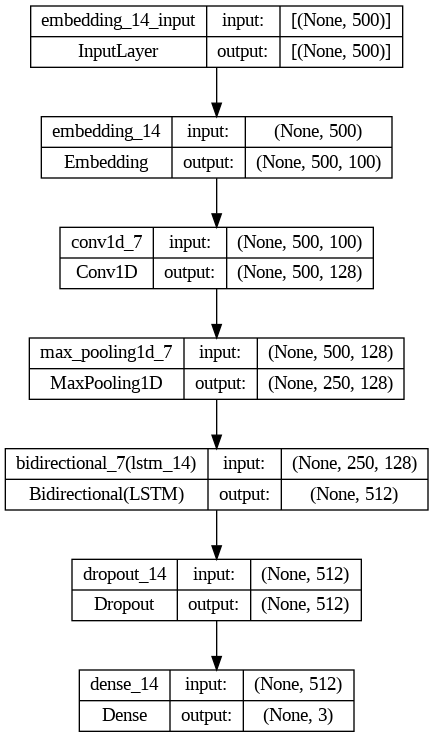

In [ ]:
tf.keras.utils.plot_model(model_tr_V2, show_shapes=True)

In [ ]:
history_tr_V2 = model_tr_V2.fit(X_train_padded, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1, callbacks=[early_stopping])
# Evaluation on Test data
test_loss, test_accuracy = model_tr_V2.evaluate(X_test_padded, y_test, verbose=1)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')
# Predictions on Test data
y_test_pred = model_tr_V2.predict(X_test_padded)
y_test_pred_classes = np.argmax(y_test_pred, axis=1)
# Calculate additional metrics
f1 = f1_score(y_test, y_test_pred_classes, average='weighted')
precision = precision_score(y_test, y_test_pred_classes, average='weighted')
recall = recall_score(y_test, y_test_pred_classes, average='weighted')
print(f'F1 Score: {f1:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')

Epoch 1/30
2250/2250 [==============================] - 159s 67ms/step - loss: 0.7696 - accuracy: 0.6623 - val_loss: 0.6791 - val_accuracy: 0.7159
Epoch 2/30
2250/2250 [==============================] - 146s 65ms/step - loss: 0.6399 - accuracy: 0.7402 - val_loss: 0.6368 - val_accuracy: 0.7394
Epoch 3/30
2250/2250 [==============================] - 147s 65ms/step - loss: 0.5984 - accuracy: 0.7618 - val_loss: 0.6143 - val_accuracy: 0.7516
Epoch 4/30
2250/2250 [==============================] - 147s 65ms/step - loss: 0.5736 - accuracy: 0.7743 - val_loss: 0.5979 - val_accuracy: 0.7613
Epoch 5/30
2250/2250 [==============================] - 148s 66ms/step - loss: 0.5562 - accuracy: 0.7840 - val_loss: 0.5837 - val_accuracy: 0.7696
Epoch 6/30
2250/2250 [==============================] - 148s 66ms/step - loss: 0.5432 - accuracy: 0.7903 - val_loss: 0.5813 - val_accuracy: 0.7710
Epoch 7/30
2250/2250 [==============================] - 148s 66ms/step - loss: 0.5317 - accuracy: 0.7955 - val_loss: 0

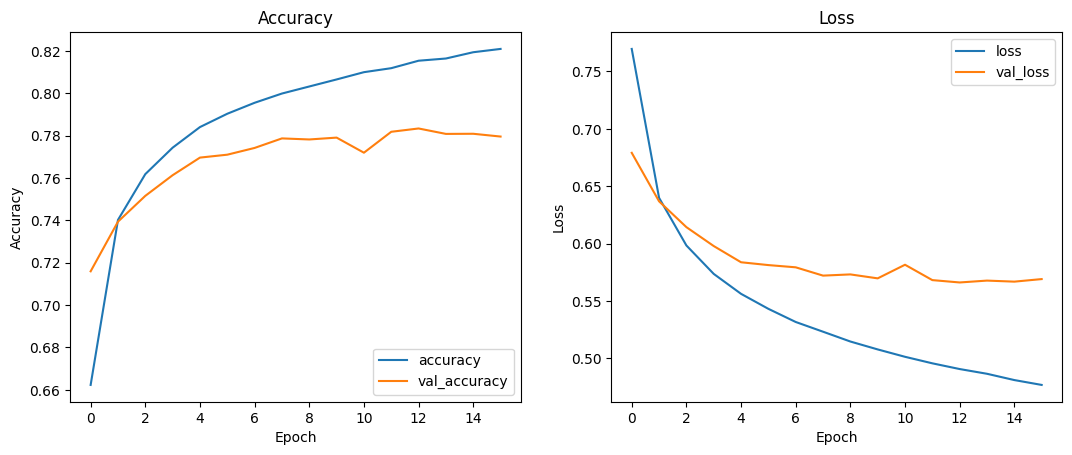

In [ ]:
# Plotting training and testing curves
default_size = plt.rcParams['figure.figsize']
fig = plt.figure(figsize=[default_size[0] * 2, default_size[1]])

fig.add_subplot(1, 2, 1)
plt.plot(history_tr_V2.history['accuracy'], label = 'accuracy')
plt.plot(history_tr_V2.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.legend(loc='lower right')

fig.add_subplot(1, 2, 2)
plt.plot(history_tr_V2.history['loss'], label='loss')
plt.plot(history_tr_V2.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend(loc='upper right')
plt.show()

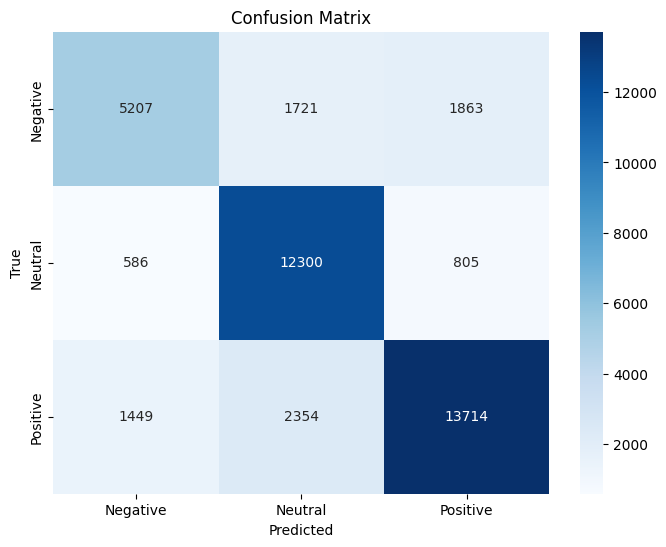

In [ ]:
# Confusion Matrix
conf_mat = confusion_matrix(y_test, y_test_pred_classes)
xlabels = ['Negative', 'Neutral', 'Positive']

# Plotting Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=xlabels, yticklabels=xlabels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()